In [41]:
import torch
import torch.nn as nn

In [42]:
import pybullet_envs
import gym
import numpy as np
from gym import wrappers
from soft_actor_critic import SoftActorCritic

In [43]:
env = gym.make('InvertedPendulumBulletEnv-v0')
print(env.action_space, env.observation_space.shape)
env.reset()

Box(-1.0, 1.0, (1,), float32) (5,)
argv[0]=
argv[0]=


array([0.        , 0.        , 0.99999718, 0.00237591, 0.        ])

In [44]:
sac = SoftActorCritic(env.observation_space.shape[0], action_dim=env.action_space.shape[0], hidden_size=64)

In [45]:
best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

In [46]:
n_episodes = 100
max_size = 10_000
batch_size = 64
learning_freq = 32

In [47]:
from replay_buffer import ReplayBuffer

replay_buffer = ReplayBuffer(max_size)

In [48]:
def play_and_record(env, agent, buffer):
    state = env.reset()
    done = False
    score = 0
    while not done:
        action = sac.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        score += reward
        buffer.add(state, action, reward, next_state, done)


        if len(buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            sac.learning_step(batch)
            
        state = next_state
    
    return score

In [49]:
n_episodes = 100_000

In [50]:
env.reset()
env.render()

array([], dtype=float64)

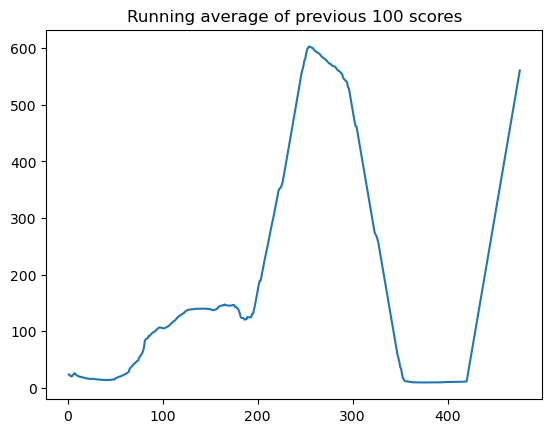

  0%|          | 480/100000 [22:24<339:53:18, 12.30s/it]

In [51]:
from tqdm import tqdm
from utils import plot_learning_curve

for i in tqdm(range(n_episodes)):
    score = play_and_record(env, sac, replay_buffer)
    # if len(replay_buffer) >= batch_size:
    #     batch = replay_buffer.sample(batch_size)
    #     sac.learning_step(batch)
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
    if i % 25 == 0 and i > 0:
        print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
        plot_learning_curve(i + 1, score_history) 

    if avg_score > 900:
        break

In [ ]:
for i in tqdm(range(250)):
    score = play_and_record(env, sac, replay_buffer)
    batch = replay_buffer.sample(batch_size)
    sac.learning_step(batch)
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
        sac.save_checkpoint()
    if i % 250 == 0 and i > 0:
        print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
        plot_learning_curve(i + 1, score_history) 

100%|██████████| 250/250 [01:24<00:00,  2.97it/s]
